In [ ]:
!pip install uv
!uv pip install datasets #trained on kaggle, so the error isnt a problem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 80.4 MB/s eta 0:00:00:00:0100:01
error: No virtual environment found; run `uv venv` to create an environment, or pass `--system` to install into a non-virtual environment


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from torch import cuda
from sklearn.utils import resample
from transformers import EarlyStoppingCallback

# Data Preparation

In [4]:
# Load labeled dataset
df = pd.read_csv("/kaggle/input/yt-comment-sentiment-labeled/indobertweet_labeled_texts.csv")
df = df[["text", "predicted_label"]]
df = df.rename(columns={"predicted_label": "label"})

In [33]:
df.duplicated().sum()

105

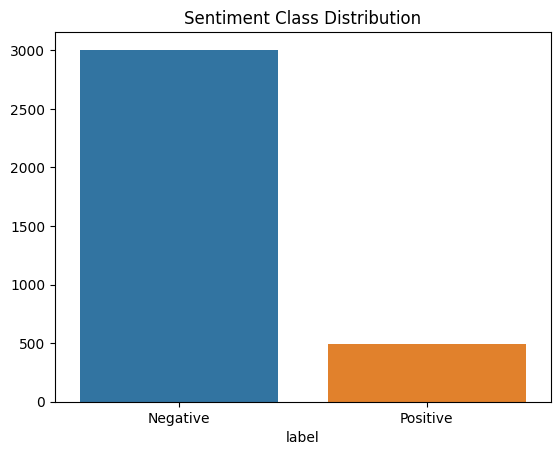

In [5]:
# Visualize
label_counts = df["label"].value_counts().sort_index()
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title("Sentiment Class Distribution")
plt.show()

In [36]:
# Oversample to match the majority class
df_majority = df[df.label == df.label.value_counts().idxmax()]
dfs = []

for label in df.label.unique():
    df_min = df[df.label == label]
    df_resampled = resample(df_min, replace=True, n_samples=len(df_majority), random_state=42)
    dfs.append(df_resampled)

df_balanced = pd.concat(dfs)
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)  # shuffle
df_balanced = df_balanced.drop_duplicates(subset=["text"])  # Replace "text" with your feature column

In [7]:
# Check class distribution
label_counts = df_balanced["label"].value_counts().sort_index()
print("Class Distribution:\n", label_counts)

Class Distribution:
 label
0    3005
1    3005
Name: count, dtype: int64


In [37]:
train_df, test_df = train_test_split(df_balanced, test_size=0.1, stratify=df_balanced["label"], random_state=42)

In [38]:
overlap = set(train_df["text"]).intersection(set(test_df["text"]))
assert len(overlap) == 0, "Data leakage still exists!"

In [9]:
# Convert to Hugging Face Datasets format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [12]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [13]:
# Load tokenizer and model
model_name = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [14]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/5409 [00:00<?, ? examples/s]

Map:   0%|          | 0/601 [00:00<?, ? examples/s]

In [15]:
# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Model Training

In [16]:
# Compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [62]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/indo-sentiment-model",
    learning_rate=3e-5,  # Lower if using >5e-5
    per_device_train_batch_size=16,
    weight_decay=0.01,  # Add L2 regularization
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Monitor validation loss
    greater_is_better=False,
    num_train_epochs=5,
    logging_steps=50,
    warmup_ratio=0.1,
    fp16=True,  # Enable mixed-precision if using GPU
    max_grad_norm=1.0,  # Prevents exploding gradients
    save_total_limit=2,          # Keeps only 2 best checkpoints
    save_steps=500,             # Save every 500 steps
    overwrite_output_dir=True,   # Clears old checkpoints
    report_to="none"
)

In [66]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=1,  # Stop if val_loss increases
            early_stopping_threshold=0.01
        )
    ]
)

In [64]:
# Train model
trainer.train(resume_from_checkpoint=False)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.125000,0.096322
2,0.026900,0.080914
3,0.015100,0.085421


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=510, training_loss=0.05072111604260463, metrics={'train_runtime': 916.3212, 'train_samples_per_second': 29.515, 'train_steps_per_second': 0.928, 'total_flos': 4269503095326720.0, 'train_loss': 0.05072111604260463, 'epoch': 3.0})

In [67]:
eval_results = trainer.evaluate(test_dataset)
eval_results  # Check *true* metrics

{'eval_loss': 0.08091381937265396,
 'eval_accuracy': 0.9950083194675541,
 'eval_precision': 0.995049504950495,
 'eval_recall': 0.9950166112956811,
 'eval_f1': 0.9950082641882407,
 'eval_runtime': 11.5773,
 'eval_samples_per_second': 51.912,
 'eval_steps_per_second': 3.282}

In [69]:
# Save model
trainer.save_model("./indo-sentiment-model/finetuned")
tokenizer.save_pretrained("./indo-sentiment-model/finetuned")

('./indo-sentiment-model/finetuned/tokenizer_config.json',
 './indo-sentiment-model/finetuned/special_tokens_map.json',
 './indo-sentiment-model/finetuned/vocab.txt',
 './indo-sentiment-model/finetuned/added_tokens.json',
 './indo-sentiment-model/finetuned/tokenizer.json')

# Inference

In [70]:
# 3. Define inference function
def predict(text):
    # Tokenize input
    inputs = tokenizer(text, 
                     padding=True, 
                     truncation=True, 
                     max_length=512, 
                     return_tensors="pt").to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Convert to probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Get predicted class and confidence
    confidence, predicted_class = torch.max(probs, dim=1)
    
    return {
        "class": predicted_class.item(),
        "confidence": confidence.item(),
        "probabilities": probs.cpu().numpy()[0]
    }

In [73]:
# 4. Example usage
sample_text = "kurang bgt mas gibran"
prediction = predict(sample_text)

print(f"Predicted class: {prediction['class']}")
print(f"Confidence: {prediction['confidence']:.4f}")

Predicted class: 0
Confidence: 1.0000
